In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential
import cv2
from imutils import paths
import argparse
import os, random, shutil
import scipy.ndimage as ndimage
#import scipy.misc as misc
from skimage.transform import resize
from PIL import *

In [113]:
#Helps with the error
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


/home/tedzed/.local/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [114]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [115]:
def get_size_statistics(DIR):
    heights = []
    widths = []
    for img in os.listdir(DIR): 
        path = os.path.join(DIR, img)
        data = np.array(Image.open(path)) #PIL Image library
        heights.append(data.shape[0])
        widths.append(data.shape[1])
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))
    return (min(heights), min(widths))
    
def resize(w,h ,DIR, newDIR):
    img = []
    for filename in os.listdir(DIR):
        image = plt.imread(os.path.join(DIR,filename))
        if len(image.shape) == 3:
            image = np.mean(image, axis=2)
            #image = resize(image, (100,100))
            image = cv2.resize(image, (w,h))
            cv2.imwrite(os.path.join(newDIR,filename), image)
        else:
            continue
    
def shuffle(DIR):
    l = os.listdir('/')
    random.shuffle(l)


def test_validate_split(DIR, split=0.8):

    os.mkdir("Data/some/Train")
    os.mkdir("Data/some/Validate")
    
    num = len(os.listdir(DIR))
    num = int(num*split)
    print(num)
    
    random.shuffle(os.listdir(DIR))
    i=0
    
    for filename in os.listdir(DIR):
        if i < num: 
            shutil.copy(os.path.join(DIR, filename), "Data/some/Train") 
            i+= 1
        else:
            shutil.copy(os.path.join(DIR, filename), "Data/some/Validate")

In [116]:
path = 'Data/newData1'
directory = 'Data/data_Master_test'
test = 'Data/test'

h, w = get_size_statistics(path)
#resize(w,h, test, path)
#test_validate_split(path)

Average Height: 117.0
Max Height: 117
Min Height: 117


Average Width: 128.0
Max Width: 128
Min Width: 128


(117, 128)


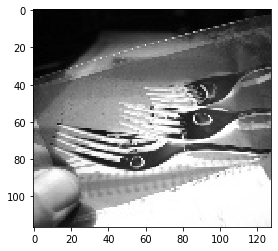

In [145]:
src = plt.imread("Data/TestData/Train/2c1e31e2accd1b5c.jpg")
plt.imshow(src, cmap="gray")
print(src.shape)

In [118]:
data = pd.read_csv("Data/labels.csv", dtype=str)

In [119]:
print(data)

                image_name class
0     00a36f96e31731c4.txt     0
1     00b729b5187a1898.txt     0
2     012b0f6b12da485f.txt     1
3     01495549e1f4fd2e.txt     0
4     024fc048dd1cb61a.txt     0
...                    ...   ...
3136    subway_wrap-79.txt     8
3137    subway_wrap-80.txt     8
3138    subway_wrap-81.txt     8
3139    subway_wrap-82.txt     8
3140    subway_wrap-83.txt     8

[3141 rows x 2 columns]


In [146]:
print(data.shape)

(3141, 2)


In [120]:
def append_ext(fn):
    name = fn.replace(".txt", ".jpg")
    return name

In [121]:
data["image_name"] = data["image_name"].apply(append_ext)

In [138]:
#Image pre-processing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator =datagen.flow_from_dataframe(dataframe=data, directory="Data/data_resized", 
                                            x_col="image_name", y_col="class", class_mode="categorical", 
                                            target_size=(128,117), batch_size=32, subset='training')


validation_generator =datagen.flow_from_dataframe(dataframe=data, directory="Data/data_resized", 
                                            x_col="image_name", y_col="class", class_mode="categorical", 
                                            target_size=(128,117), batch_size=32, subset='validation')

Found 1864 validated image filenames belonging to 9 classes.
Found 465 validated image filenames belonging to 9 classes.


In [147]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,117,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(9,activation='sigmoid'))
 
model.compile(loss='categorical_crossentropy',optimizer = 'Adam',metrics=['accuracy'])

In [149]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n //validation_generator.batch_size

history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=20,
                              validation_data=validation_generator,validation_steps=validation_steps)

Epoch 1/20
58/58 [==============================] - 1s 17ms/step - loss: 1.6466 - accuracy: 0.3592 - val_loss: 1.9368 - val_accuracy: 0.3192
Epoch 2/20
58/58 [==============================] - 1s 17ms/step - loss: 1.5387 - accuracy: 0.3684 - val_loss: 1.5165 - val_accuracy: 0.3279
Epoch 3/20
58/58 [==============================] - 1s 18ms/step - loss: 1.4523 - accuracy: 0.3755 - val_loss: 2.0239 - val_accuracy: 0.3441
Epoch 4/20
58/58 [==============================] - 1s 16ms/step - loss: 1.4067 - accuracy: 0.3936 - val_loss: 1.4220 - val_accuracy: 0.4042
Epoch 5/20
58/58 [==============================] - 1s 17ms/step - loss: 1.3279 - accuracy: 0.4307 - val_loss: 1.3474 - val_accuracy: 0.3834
Epoch 6/20
58/58 [==============================] - 1s 16ms/step - loss: 1.2326 - accuracy: 0.4693 - val_loss: 1.4813 - val_accuracy: 0.4226
Epoch 7/20
58/58 [==============================] - 1s 17ms/step - loss: 1.1626 - accuracy: 0.5028 - val_loss: 2.0011 - val_accuracy: 0.3649
Epoch 8/20
58

In [150]:
#def predict_image():
def history_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    
    
def history_of_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

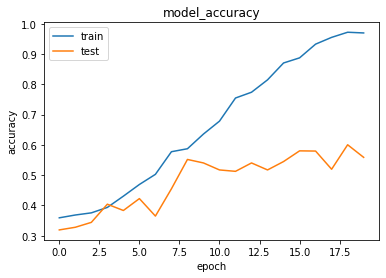

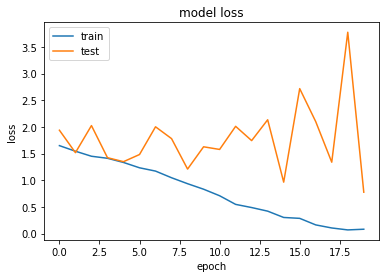

In [151]:
history_accuracy(history)
history_of_loss(history)

In [156]:
path = "Data/TestData/test"
resize(127,117, path, path)
img = plt.imread("Data/TestData/test/bottle.jpg")
#model.predict(img)